# 제20강 워드 임베딩 (1) 분포 가설, 코사인 유사도, TF-IDF

**2025년 12월 1일 월요일**

---

## 오늘의 목표

1. 분포 가설의 개념을 이해하고 언어학적 의의를 설명할 수 있다.
2. 코사인 유사도를 계산하고 단어 간 유사성을 측정할 수 있다.
3. TF-IDF 벡터를 활용하여 문서 및 단어 유사도를 분석할 수 있다.

## 0. 환경 설정

In [ ]:
# 필요한 라이브러리 설치
# !pip install datasets scikit-learn pandas numpy matplotlib seaborn

In [ ]:
# 한글 폰트 파일 다운로드
# !mkdir -p ../fonts
# !wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip -O ../fonts/NotoSansCJKkr-hinted.zip
# !unzip ../fonts/NotoSansCJKkr-hinted.zip -d ../fonts
# !rm ../fonts/NotoSansCJKkr-hinted.zip

In [1]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 한글 폰트 설정
import matplotlib.font_manager as fm

# 한글 폰트 설정 (matplotlib)
font_dir = ['../fonts']
for font in fm.findSystemFonts(font_dir):
    fm.fontManager.addfont(font)

plt.rcParams['font.family'] = 'Noto Sans CJK KR'
plt.rcParams['axes.unicode_minus'] = False

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

print("라이브러리 로드 완료!")

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


라이브러리 로드 완료!


---

## 1. 분포 가설 (Distributional Hypothesis)

### 1.1 핵심 개념

> **"비슷한 문맥에 등장하는 단어는 비슷한 의미를 가진다."**
>
> — J.R. Firth (1957): "You shall know a word by the company it keeps."

### 1.2 분포적 유사성 예시

아래 문장들에서 빈칸에 들어갈 수 있는 단어들을 생각해 보자.

In [2]:
# 정도부사의 분포 예시
contexts = [
    "오늘 날씨가 _____ 좋다",
    "이 영화는 _____ 재미있다",
    "음식이 _____ 맛있다",
    "그 사람은 _____ 친절하다"
]

adverbs = ["아주", "매우", "정말", "완전", "되게"]

print("정도부사가 들어갈 수 있는 문맥들:")
print("=" * 40)
for ctx in contexts:
    print(ctx)

print("\n이 문맥에 들어갈 수 있는 단어들:")
print(adverbs)
print("\n→ 이 단어들은 비슷한 문맥에서 사용되므로 의미적으로 유사하다고 추론할 수 있다.")

정도부사가 들어갈 수 있는 문맥들:
오늘 날씨가 _____ 좋다
이 영화는 _____ 재미있다
음식이 _____ 맛있다
그 사람은 _____ 친절하다

이 문맥에 들어갈 수 있는 단어들:
['아주', '매우', '정말', '완전', '되게']

→ 이 단어들은 비슷한 문맥에서 사용되므로 의미적으로 유사하다고 추론할 수 있다.


### 1.3 단어-문맥 행렬 만들기

단어가 어떤 문맥에서 등장하는지를 행렬로 표현해 보자.

In [3]:
# 간단한 단어-문맥 행렬 예시
# 행: 단어, 열: 문맥 단어 (함께 등장한 횟수)

word_context_data = {
    '마시다': [15, 12, 10, 0],
    '먹다': [2, 1, 0, 20],
    '뜨겁다': [8, 6, 0, 1],
    '차갑다': [3, 4, 7, 0],
    '맛있다': [5, 3, 6, 12]
}

words = ['커피', '차', '주스', '밥']

word_context_df = pd.DataFrame(word_context_data, index=words)
print("단어-문맥 행렬 (행: 단어, 열: 문맥 단어)")
print("=" * 50)
print(word_context_df)

단어-문맥 행렬 (행: 단어, 열: 문맥 단어)
    마시다  먹다  뜨겁다  차갑다  맛있다
커피   15   2    8    3    5
차    12   1    6    4    3
주스   10   0    0    7    6
밥     0  20    1    0   12


In [4]:
# 각 단어의 벡터 표현
print("각 단어의 벡터 표현:")
print("=" * 50)
for word in words:
    vector = word_context_df.loc[word].values
    print(f"'{word}' = {vector}")

각 단어의 벡터 표현:
'커피' = [15  2  8  3  5]
'차' = [12  1  6  4  3]
'주스' = [10  0  0  7  6]
'밥' = [ 0 20  1  0 12]


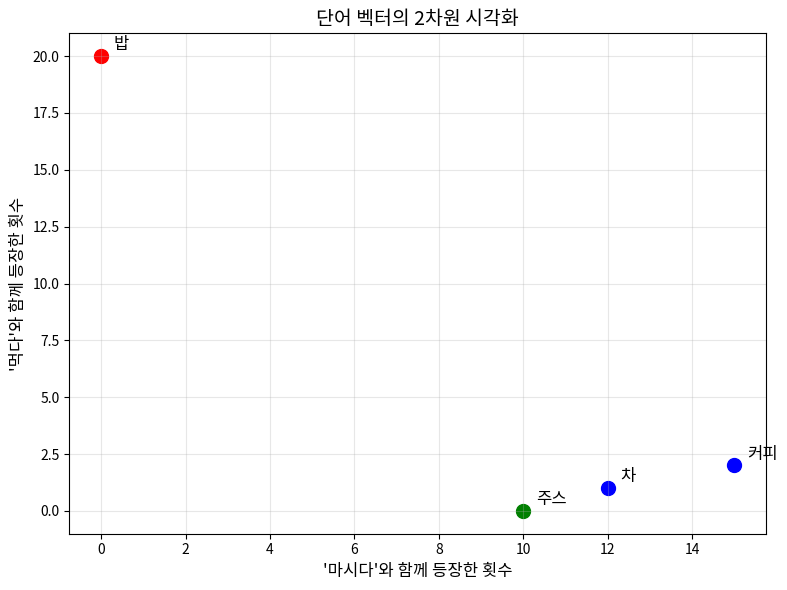


관찰: '커피'와 '차'는 가까운 위치에, '밥'은 멀리 떨어져 있다.


In [5]:
# 단어 벡터 시각화 (2차원으로 축소하여 표현)
fig, ax = plt.subplots(figsize=(8, 6))

# '마시다'와 '먹다' 차원만 사용하여 2D 시각화
x = word_context_df['마시다'].values
y = word_context_df['먹다'].values

colors = ['blue', 'blue', 'green', 'red']
for i, word in enumerate(words):
    ax.scatter(x[i], y[i], c=colors[i], s=100)
    ax.annotate(word, (x[i]+0.3, y[i]+0.3), fontsize=12)

ax.set_xlabel("'마시다'와 함께 등장한 횟수", fontsize=12)
ax.set_ylabel("'먹다'와 함께 등장한 횟수", fontsize=12)
ax.set_title("단어 벡터의 2차원 시각화", fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n관찰: '커피'와 '차'는 가까운 위치에, '밥'은 멀리 떨어져 있다.")

---

## 2. 코사인 유사도 (Cosine Similarity)

### 2.1 코사인 유사도란?

두 벡터 사이의 각도를 이용하여 유사도를 측정하는 방법.

$$\cos(\theta) = \frac{\mathbf{A} \cdot \mathbf{B}}{|\mathbf{A}| \times |\mathbf{B}|} = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \times \sqrt{\sum_{i=1}^{n} B_i^2}}$$

- 값의 범위: [-1, 1] (TF-IDF의 경우 [0, 1])
- 1에 가까울수록 유사, 0에 가까울수록 무관

### 2.2 코사인 유사도 직접 계산하기

In [6]:
# 두 벡터 정의
A = np.array([0.5, 0.3, 0.0, 0.2])
B = np.array([0.4, 0.4, 0.1, 0.1])

print("벡터 A:", A)
print("벡터 B:", B)

벡터 A: [0.5 0.3 0.  0.2]
벡터 B: [0.4 0.4 0.1 0.1]


In [7]:
# 1단계: 내적 (dot product) 계산
dot_product = np.dot(A, B)
print("1단계: 내적 계산")
print(f"A · B = (0.5×0.4) + (0.3×0.4) + (0.0×0.1) + (0.2×0.1)")
print(f"     = 0.20 + 0.12 + 0.00 + 0.02")
print(f"     = {dot_product}")

1단계: 내적 계산
A · B = (0.5×0.4) + (0.3×0.4) + (0.0×0.1) + (0.2×0.1)
     = 0.20 + 0.12 + 0.00 + 0.02
     = 0.34


In [8]:
# 2단계: 벡터 크기 (L2 norm) 계산
norm_A = np.linalg.norm(A)
norm_B = np.linalg.norm(B)

print("2단계: 벡터 크기 계산")
print(f"|A| = √(0.5² + 0.3² + 0.0² + 0.2²) = √{np.sum(A**2):.4f} = {norm_A:.4f}")
print(f"|B| = √(0.4² + 0.4² + 0.1² + 0.1²) = √{np.sum(B**2):.4f} = {norm_B:.4f}")

2단계: 벡터 크기 계산
|A| = √(0.5² + 0.3² + 0.0² + 0.2²) = √0.3800 = 0.6164
|B| = √(0.4² + 0.4² + 0.1² + 0.1²) = √0.3400 = 0.5831


In [9]:
# 3단계: 코사인 유사도 계산
cosine_sim = dot_product / (norm_A * norm_B)

print("3단계: 코사인 유사도 계산")
print(f"cos(θ) = {dot_product:.4f} / ({norm_A:.4f} × {norm_B:.4f})")
print(f"       = {dot_product:.4f} / {norm_A * norm_B:.4f}")
print(f"       = {cosine_sim:.4f}")
print(f"\n결론: 두 벡터의 코사인 유사도는 약 {cosine_sim:.2f}로, 매우 유사하다.")

3단계: 코사인 유사도 계산
cos(θ) = 0.3400 / (0.6164 × 0.5831)
       = 0.3400 / 0.3594
       = 0.9459

결론: 두 벡터의 코사인 유사도는 약 0.95로, 매우 유사하다.


### 2.3 NumPy와 scikit-learn으로 계산하기

In [10]:
# 방법 1: NumPy로 직접 계산
def cosine_similarity_manual(vec1, vec2):
    """두 벡터의 코사인 유사도 계산"""
    dot = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot / (norm1 * norm2)

result1 = cosine_similarity_manual(A, B)
print(f"NumPy 직접 계산: {result1:.4f}")

NumPy 직접 계산: 0.9459


In [11]:
# 방법 2: scikit-learn 사용
from sklearn.metrics.pairwise import cosine_similarity

# 2D 배열로 변환 (행 = 샘플)
result2 = cosine_similarity([A], [B])[0][0]
print(f"scikit-learn 계산: {result2:.4f}")

scikit-learn 계산: 0.9459


### 2.4 여러 벡터 간 유사도 행렬

In [12]:
# 앞서 만든 단어-문맥 행렬로 단어 간 유사도 계산
word_vectors = word_context_df.values  # (4, 5) 행렬

# 모든 단어 쌍의 코사인 유사도 계산
similarity_matrix = cosine_similarity(word_vectors)

# DataFrame으로 보기 좋게 출력
sim_df = pd.DataFrame(
    similarity_matrix,
    index=words,
    columns=words
)

print("단어 간 코사인 유사도 행렬:")
print("=" * 50)
print(sim_df.round(3))

단어 간 코사인 유사도 행렬:
       커피      차     주스      밥
커피  1.000  0.990  0.817  0.256
차   0.990  1.000  0.850  0.185
주스  0.817  0.850  1.000  0.227
밥   0.256  0.185  0.227  1.000


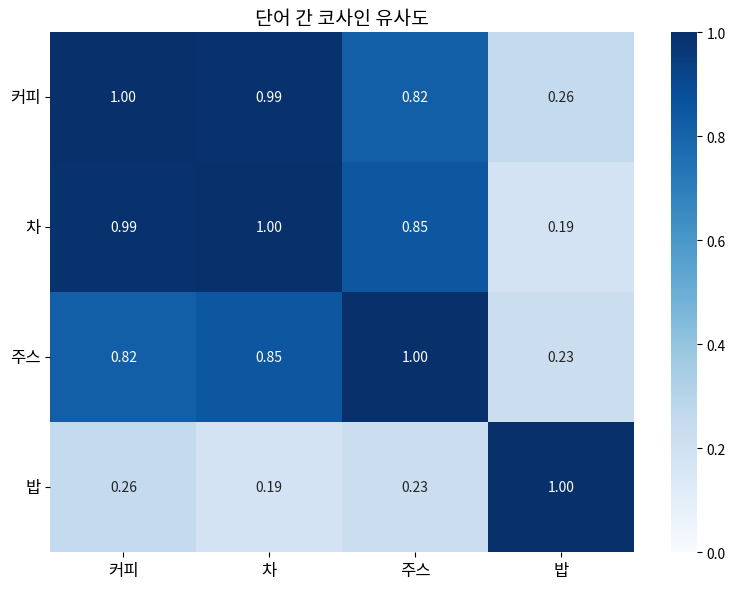


관찰: '커피'와 '차'의 유사도가 높고, '밥'은 다른 단어들과 유사도가 낮다.


In [13]:
# 히트맵으로 시각화
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    sim_df,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    vmin=0,
    vmax=1,
    ax=ax
)

# 한글 레이블 설정
ax.set_xticklabels(words, fontsize=12)
ax.set_yticklabels(words, fontsize=12, rotation=0)
ax.set_title("단어 간 코사인 유사도", fontsize=14)

plt.tight_layout()
plt.show()

print("\n관찰: '커피'와 '차'의 유사도가 높고, '밥'은 다른 단어들과 유사도가 낮다.")

### 2.5 왜 유클리드 거리가 아닌 코사인 유사도인가?

In [14]:
# 문서 길이의 영향 비교
# 같은 내용이지만 길이가 다른 두 문서
doc_short = np.array([1, 2, 0, 1])   # 짧은 문서
doc_long = np.array([2, 4, 0, 2])    # 긴 문서 (같은 비율, 2배 길이)
doc_diff = np.array([0, 1, 3, 2])    # 다른 내용의 문서

print("문서 벡터:")
print(f"짧은 문서: {doc_short}")
print(f"긴 문서:   {doc_long} (같은 내용, 2배 길이)")
print(f"다른 문서: {doc_diff}")

문서 벡터:
짧은 문서: [1 2 0 1]
긴 문서:   [2 4 0 2] (같은 내용, 2배 길이)
다른 문서: [0 1 3 2]


In [15]:
from sklearn.metrics.pairwise import euclidean_distances

# 유클리드 거리
print("유클리드 거리:")
print(f"  짧은 문서 ↔ 긴 문서: {np.linalg.norm(doc_short - doc_long):.4f}")
print(f"  짧은 문서 ↔ 다른 문서: {np.linalg.norm(doc_short - doc_diff):.4f}")

print("\n코사인 유사도:")
print(f"  짧은 문서 ↔ 긴 문서: {cosine_similarity([doc_short], [doc_long])[0][0]:.4f}")
print(f"  짧은 문서 ↔ 다른 문서: {cosine_similarity([doc_short], [doc_diff])[0][0]:.4f}")

print("\n결론:")
print("  - 유클리드 거리는 문서 길이에 영향을 받음")
print("  - 코사인 유사도는 방향(내용 비율)만 비교하여 길이 영향 없음")

유클리드 거리:
  짧은 문서 ↔ 긴 문서: 2.4495
  짧은 문서 ↔ 다른 문서: 3.4641

코사인 유사도:
  짧은 문서 ↔ 긴 문서: 1.0000
  짧은 문서 ↔ 다른 문서: 0.4364

결론:
  - 유클리드 거리는 문서 길이에 영향을 받음
  - 코사인 유사도는 방향(내용 비율)만 비교하여 길이 영향 없음


---

## 3. TF-IDF를 활용한 유사도 분석

### 3.1 NSMC 데이터 로드

In [16]:
# NSMC 데이터셋 로드
print("NSMC 데이터셋 로드 중...")
dataset = load_dataset("Blpeng/nsmc")

# DataFrame으로 변환
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

print(f"학습 데이터: {len(train_df):,}개")
print(f"테스트 데이터: {len(test_df):,}개")

NSMC 데이터셋 로드 중...


Repo card metadata block was not found. Setting CardData to empty.


학습 데이터: 150,000개
테스트 데이터: 50,000개


In [17]:
# 데이터 전처리
train_df = train_df.dropna(subset=['document'])
train_df = train_df[train_df['document'].str.strip() != '']

# 실습을 위해 샘플링 (전체 데이터 사용 시 시간이 오래 걸림)
sample_size = 5000
sample_df = train_df.sample(n=sample_size, random_state=42).reset_index(drop=True)

print(f"샘플 데이터: {len(sample_df):,}개")
print(f"\n레이블 분포:")
print(sample_df['label'].value_counts())

샘플 데이터: 5,000개

레이블 분포:
label
0    2540
1    2460
Name: count, dtype: int64


In [18]:
# 데이터 샘플 확인
print("데이터 샘플:")
print("=" * 70)
for i in range(5):
    label = "긍정" if sample_df.iloc[i]['label'] == 1 else "부정"
    doc = sample_df.iloc[i]['document'][:60]
    print(f"[{label}] {doc}...")

데이터 샘플:
[긍정] 원본이 최고...
[긍정] 스릴감과 훈훈함이 있는 영화....
[긍정] 굉장히 저평가되는 영화중 하나라고 생각함...
[긍정] 정말영화같은이야기 영화여서 영화같은이야기가 좋다...
[부정] 계기도없는데 이상하다...


### 3.2 TF-IDF 벡터화

In [19]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer(
    max_features=5000,    # 상위 5000개 단어만 사용
    min_df=3,             # 최소 3개 문서에 등장한 단어만
    max_df=0.9,           # 90% 이상 문서에 등장한 단어 제외
    ngram_range=(1, 2)    # 유니그램 + 바이그램
)

# TF-IDF 행렬 생성
tfidf_matrix = vectorizer.fit_transform(sample_df['document'])

print(f"TF-IDF 행렬 크기: {tfidf_matrix.shape}")
print(f"  - 문서 수: {tfidf_matrix.shape[0]:,}")
print(f"  - 단어(특성) 수: {tfidf_matrix.shape[1]:,}")

TF-IDF 행렬 크기: (5000, 2058)
  - 문서 수: 5,000
  - 단어(특성) 수: 2,058


In [20]:
# 어휘 사전 확인
feature_names = vectorizer.get_feature_names_out()
print(f"어휘 사전 크기: {len(feature_names)}")
print(f"\n어휘 샘플 (처음 20개):")
print(feature_names[:20])

어휘 사전 크기: 2058

어휘 샘플 (처음 20개):
['0점' '10' '10년이' '10자' '10점' '10점만점에' '10점을' '10점이' '10점주는' '1시간' '1위'
 '1점' '1점도' '1점도 아깝다' '1점은' '1편' '1편에' '1편은' '1편이' '20년전']


### 3.3 문서 유사도 측정

In [21]:
def find_similar_documents(query_idx, tfidf_matrix, docs_df, top_n=5):
    """
    특정 문서와 가장 유사한 문서들 찾기
    
    Parameters:
    - query_idx: 쿼리 문서의 인덱스
    - tfidf_matrix: TF-IDF 행렬
    - docs_df: 문서 DataFrame
    - top_n: 반환할 유사 문서 수
    """
    # 쿼리 벡터
    query_vec = tfidf_matrix[query_idx]
    
    # 모든 문서와의 유사도 계산
    similarities = cosine_similarity(query_vec, tfidf_matrix)[0]
    
    # 유사도 높은 순으로 정렬 (자기 자신 제외)
    similar_indices = similarities.argsort()[::-1][1:top_n+1]
    
    # 결과 출력
    query_label = "긍정" if docs_df.iloc[query_idx]['label'] == 1 else "부정"
    print(f"쿼리 문서 [{query_label}]:")
    print(f"  {docs_df.iloc[query_idx]['document']}")
    print("\n" + "=" * 70)
    print(f"유사한 문서 Top {top_n}:")
    print("=" * 70)
    
    for rank, idx in enumerate(similar_indices, 1):
        label = "긍정" if docs_df.iloc[idx]['label'] == 1 else "부정"
        sim = similarities[idx]
        doc = docs_df.iloc[idx]['document'][:60]
        print(f"{rank}. [{label}] (유사도: {sim:.3f})")
        print(f"   {doc}...")
        print()

In [22]:
# 첫 번째 문서와 유사한 문서 찾기
find_similar_documents(0, tfidf_matrix, sample_df, top_n=5)

쿼리 문서 [긍정]:
  원본이 최고

유사한 문서 Top 5:
1. [긍정] (유사도: 1.000)
   최고....

2. [긍정] (유사도: 1.000)
   최고 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ최고의b급영화...

3. [긍정] (유사도: 1.000)
   윤아짱 최고...

4. [긍정] (유사도: 1.000)
   최고...

5. [긍정] (유사도: 1.000)
   최고...



In [23]:
# 다른 문서로도 테스트
find_similar_documents(100, tfidf_matrix, sample_df, top_n=5)

쿼리 문서 [부정]:
  잘시간줄여서 받아본게 아깝다겉으로 평화가 어쨌네 저쨌네하면서울나라하고 중국이 지네 위협될성싶으니 한나라로묶어서 그려놨네열도 털린것도 힘이 없어 털린거고주인공은는 도저히 통일교 문선명할배말고는 생각안됨시간아깝다

유사한 문서 Top 5:
1. [긍정] (유사도: 0.513)
   저 별엔 미래가 없어......

2. [긍정] (유사도: 0.513)
   총을 쏘았다는데 총알이 없어. 탄피도 없어. 다쳤는데 왜 다쳤는지를 모르겠네. 개법부를 엎어버려야지 원...

3. [부정] (유사도: 0.458)
   kbs에서 틀어주길래 30분?좀넘게 보고있는데 도저히 답이안나온다.. 저녁에먹은 볶음밥이 십이지장에서 올라오...

4. [부정] (유사도: 0.429)
   발상은 좋으나 이야기에 힘이 부족하다....

5. [부정] (유사도: 0.397)
   역시 캐릭터만 빌려서는 잘될수가 없어....



### 3.4 긍정/부정 리뷰 간 유사도 패턴

In [24]:
# 긍정/부정 리뷰 분리 (샘플)
n_sample = 200  # 계산 효율을 위해 각 클래스에서 200개씩 샘플링

pos_indices = sample_df[sample_df['label'] == 1].index[:n_sample].tolist()
neg_indices = sample_df[sample_df['label'] == 0].index[:n_sample].tolist()

print(f"긍정 리뷰 샘플: {len(pos_indices)}개")
print(f"부정 리뷰 샘플: {len(neg_indices)}개")

긍정 리뷰 샘플: 200개
부정 리뷰 샘플: 200개


In [25]:
# 유사도 계산
# 긍정-긍정 유사도
pos_matrix = tfidf_matrix[pos_indices]
pos_sim = cosine_similarity(pos_matrix)
# 대각선(자기 자신과의 유사도 = 1) 제외한 평균
pos_avg = (pos_sim.sum() - len(pos_indices)) / (len(pos_indices)**2 - len(pos_indices))

# 부정-부정 유사도
neg_matrix = tfidf_matrix[neg_indices]
neg_sim = cosine_similarity(neg_matrix)
neg_avg = (neg_sim.sum() - len(neg_indices)) / (len(neg_indices)**2 - len(neg_indices))

# 긍정-부정 유사도
cross_sim = cosine_similarity(pos_matrix, neg_matrix)
cross_avg = cross_sim.mean()

print("평균 코사인 유사도:")
print("=" * 40)
print(f"긍정 ↔ 긍정: {pos_avg:.4f}")
print(f"부정 ↔ 부정: {neg_avg:.4f}")
print(f"긍정 ↔ 부정: {cross_avg:.4f}")

평균 코사인 유사도:
긍정 ↔ 긍정: 0.0051
부정 ↔ 부정: 0.0027
긍정 ↔ 부정: 0.0034


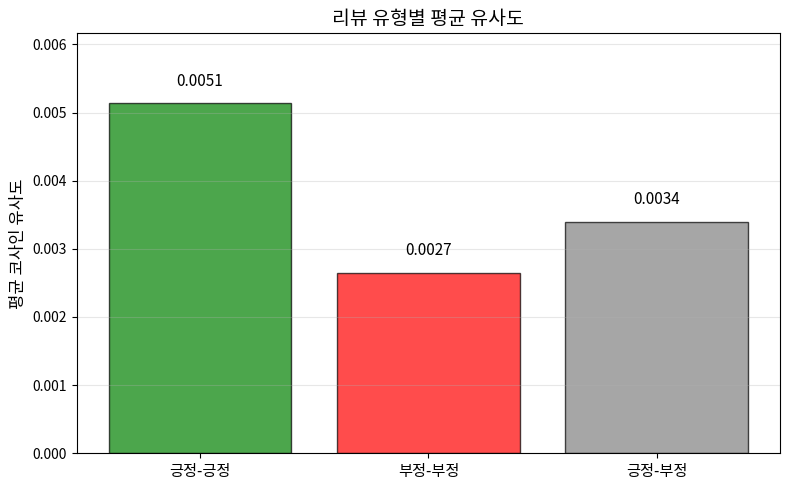


해석:
  - 같은 감정의 리뷰끼리 유사도가 높음
  - 다른 감정의 리뷰 사이는 유사도가 낮음
  → TF-IDF 벡터가 감정을 어느 정도 반영하고 있음


In [26]:
# 결과 시각화
fig, ax = plt.subplots(figsize=(8, 5))

categories = ['긍정-긍정', '부정-부정', '긍정-부정']
values = [pos_avg, neg_avg, cross_avg]
colors = ['green', 'red', 'gray']

bars = ax.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')

# 값 표시
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0002,
            f'{val:.4f}', ha='center', va='bottom', fontsize=11)

ax.set_ylabel('평균 코사인 유사도', fontsize=12)
ax.set_title('리뷰 유형별 평균 유사도', fontsize=14)
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, max(values) * 1.2)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n해석:")
print("  - 같은 감정의 리뷰끼리 유사도가 높음")
print("  - 다른 감정의 리뷰 사이는 유사도가 낮음")
print("  → TF-IDF 벡터가 감정을 어느 정도 반영하고 있음")

### 3.5 단어 유사도 측정

In [27]:
# TF-IDF 행렬 전치: 단어가 행이 됨
tfidf_words = tfidf_matrix.T  # (단어 수, 문서 수)

print(f"전치 행렬 크기: {tfidf_words.shape}")
print(f"  - 단어 수: {tfidf_words.shape[0]:,}")
print(f"  - 문서 수: {tfidf_words.shape[1]:,}")

전치 행렬 크기: (2058, 5000)
  - 단어 수: 2,058
  - 문서 수: 5,000


In [28]:
def find_similar_words(query_word, tfidf_words, feature_names, top_n=10):
    """
    특정 단어와 가장 유사한 단어들을 찾습니다.
    
    Parameters:
    - query_word: 쿼리 단어
    - tfidf_words: 전치된 TF-IDF 행렬 (단어 × 문서)
    - feature_names: 단어 목록
    - top_n: 반환할 유사 단어 수
    """
    # 쿼리 단어가 어휘에 있는지 확인
    if query_word not in feature_names:
        print(f"'{query_word}'가 어휘 사전에 없습니다.")
        # 부분 일치하는 단어 제안
        suggestions = [w for w in feature_names if query_word in w][:5]
        if suggestions:
            print(f"유사한 단어: {suggestions}")
        return
    
    # 쿼리 단어의 인덱스
    query_idx = np.where(feature_names == query_word)[0][0]
    query_vec = tfidf_words[query_idx]
    
    # 모든 단어와의 유사도 계산
    similarities = cosine_similarity(query_vec, tfidf_words)[0]
    
    # 유사도 높은 순으로 정렬 (자기 자신 제외)
    similar_indices = similarities.argsort()[::-1][1:top_n+1]
    
    # 결과 출력
    print(f"'{query_word}'와 유사한 단어 Top {top_n}:")
    print("=" * 40)
    for rank, idx in enumerate(similar_indices, 1):
        word = feature_names[idx]
        sim = similarities[idx]
        print(f"{rank:2d}. {word}: {sim:.4f}")

In [29]:
# 긍정적인 단어와 유사한 단어 찾기
find_similar_words("재미있다", tfidf_words, feature_names)

'재미있다'와 유사한 단어 Top 10:
 1. 설정과: 0.1592
 2. 자연스러운: 0.1254
 3. 지금봐도: 0.1253
 4. 지금 봐도: 0.1226
 5. 웃음이: 0.0888
 6. 진심: 0.0887
 7. 완전: 0.0622
 8. 몇번을: 0.0598
 9. 나온다: 0.0568
10. 너무나: 0.0536


In [30]:
# 부정적인 단어와 유사한 단어 찾기
find_similar_words("지루하다", tfidf_words, feature_names)

'지루하다'와 유사한 단어 Top 10:
 1. 너무 지루하다: 0.3151
 2. 한국영화는: 0.1427
 3. 전개가: 0.1366
 4. 재미없고: 0.1019
 5. 전체적으로: 0.0959
 6. 분위기는: 0.0770
 7. 좋은데: 0.0742
 8. 초반에: 0.0739
 9. 평점에: 0.0702
10. 괜찮은데: 0.0699


In [31]:
# 다른 단어들도 테스트
test_words = ["최고", "최악", "감동", "실망"]

for word in test_words:
    print()
    find_similar_words(word, tfidf_words, feature_names, top_n=5)


'최고'와 유사한 단어 Top 5:
 1. 드라마중: 0.1400
 2. 드라마중 최고: 0.1400
 3. 정말 최고: 0.1324
 4. 뮤지컬: 0.0885
 5. 감독도: 0.0637

'최악'와 유사한 단어 Top 5:
 1. 시리즈중: 0.1413
 2. 영화중에: 0.1276
 3. 뻔하고: 0.1094
 4. 미친: 0.1016
 5. 진부하고: 0.0869

'감동'와 유사한 단어 Top 5:
 1. 정말 감동: 0.3026
 2. 소재로: 0.1458
 3. 억지: 0.1373
 4. 임창정: 0.1320
 5. 아픈: 0.1173

'실망'와 유사한 단어 Top 5:
 1. 기대했는데: 0.2533
 2. 부분: 0.2343
 3. 너무 재미없다: 0.1831
 4. 마무리: 0.1477
 5. 하루에: 0.1130


---

## 4. TF-IDF의 한계

### 4.1 희소성 문제

In [32]:
# TF-IDF 행렬의 희소성 확인
total_elements = tfidf_matrix.shape[0] * tfidf_matrix.shape[1]
nonzero_elements = tfidf_matrix.nnz  # 0이 아닌 원소 개수
sparsity = 1 - (nonzero_elements / total_elements)

print("TF-IDF 행렬의 희소성:")
print("=" * 40)
print(f"전체 원소 수: {total_elements:,}")
print(f"0이 아닌 원소 수: {nonzero_elements:,}")
print(f"희소성 (Sparsity): {sparsity:.4%}")
print(f"\n→ {sparsity:.2%}의 값이 0이다!")

TF-IDF 행렬의 희소성:
전체 원소 수: 10,290,000
0이 아닌 원소 수: 16,151
희소성 (Sparsity): 99.8430%

→ 99.84%의 값이 0이다!


### 4.2 동의어 문제

In [33]:
# 동의어 쌍의 유사도 확인
synonym_pairs = [
    ("재미있다", "재밌다"),
    ("좋다", "훌륭하다"),
    ("나쁘다", "안좋다"),
]

print("동의어 쌍의 코사인 유사도:")
print("=" * 50)

for word1, word2 in synonym_pairs:
    # 두 단어 모두 어휘에 있는지 확인
    if word1 in feature_names and word2 in feature_names:
        idx1 = np.where(feature_names == word1)[0][0]
        idx2 = np.where(feature_names == word2)[0][0]
        sim = cosine_similarity(tfidf_words[idx1], tfidf_words[idx2])[0][0]
        print(f"'{word1}' ↔ '{word2}': {sim:.4f}")
    else:
        missing = [w for w in [word1, word2] if w not in feature_names]
        print(f"'{word1}' ↔ '{word2}': 어휘에 없음 ({missing})")

print("\n→ 동의어라도 TF-IDF에서는 다른 차원으로 취급된다.")

동의어 쌍의 코사인 유사도:
'재미있다' ↔ '재밌다': 0.0000
'좋다' ↔ '훌륭하다': 0.1138
'나쁘다' ↔ '안좋다': 어휘에 없음 (['나쁘다', '안좋다'])

→ 동의어라도 TF-IDF에서는 다른 차원으로 취급된다.


### 4.3 문맥 무시 문제

In [34]:
# 어순이 다른 문장 비교
sentences = [
    "영화가 재미없지 않다",    # 이중 부정 = 긍정
    "영화가 재미있지 않다",    # 부정
    "영화가 재미있다"          # 긍정
]

# TF-IDF 변환
sent_vectors = vectorizer.transform(sentences)

# 유사도 계산
sent_sim = cosine_similarity(sent_vectors)

print("문장 간 코사인 유사도:")
print("=" * 50)
for i, sent1 in enumerate(sentences):
    for j, sent2 in enumerate(sentences):
        if i < j:
            print(f"'{sent1}'")
            print(f"  ↔ '{sent2}'")
            print(f"  유사도: {sent_sim[i][j]:.4f}")
            print()

print("→ TF-IDF는 단어 순서를 무시하여 의미 차이를 구분하기 어렵다.")

문장 간 코사인 유사도:
'영화가 재미없지 않다'
  ↔ '영화가 재미있지 않다'
  유사도: 1.0000

'영화가 재미없지 않다'
  ↔ '영화가 재미있다'
  유사도: 0.3534

'영화가 재미있지 않다'
  ↔ '영화가 재미있다'
  유사도: 0.3534

→ TF-IDF는 단어 순서를 무시하여 의미 차이를 구분하기 어렵다.


---

## 5. 정리

### 오늘 배운 내용

1. **분포 가설 (Distributional Hypothesis)**
   - 비슷한 문맥에 등장하는 단어는 비슷한 의미를 가진다
   - 단어의 의미를 문맥 벡터로 표현할 수 있다

2. **코사인 유사도 (Cosine Similarity)**
   - 두 벡터 사이의 각도를 이용한 유사도 측정
   - 문서 길이에 영향받지 않음 (방향만 비교)
   - $\cos(\theta) = \frac{\mathbf{A} \cdot \mathbf{B}}{|\mathbf{A}||\mathbf{B}|}$

3. **TF-IDF 활용**
   - 문서 유사도: TF-IDF 행렬의 행 벡터 비교
   - 단어 유사도: TF-IDF 행렬의 열 벡터 비교 (전치 후 행)

4. **TF-IDF의 한계**
   - 희소성 문제: 대부분의 값이 0
   - 동의어 문제: 같은 의미의 단어가 다른 차원
   - 문맥 무시: 단어 순서 정보 없음

### 다음 시간 예고

**제21강: 워드 임베딩 (2) Word2Vec**
- 밀집 벡터 (Dense Vector)로 단어 표현
- Skip-gram과 CBOW 알고리즘
- 단어 벡터의 산술 연산: "king" - "man" + "woman" = "queen"